### 任務介紹
一位隕石的廠商找上了你，他平常做的生意是買低賣高，只要購買克價低於一般隕石販賣克價就能轉賣獲利(就像黃金收購克價低於市價就能轉賣獲利)。
而這陣子發現一種新型隕石，而且統一被一個集團給挖掘完，他們即將開放競標，但困難點是每個競標品他們只願提供最大長邊，不願意提供詳細尺寸/克重。

由於沒有克重，無法換算最高標可接受多少錢，廠商希望你幫他建一個模型，當他輸入最大長邊時，估計那個隕石的重量為何以便他競標(更好的話，告訴他可能的誤差是多少，他可以臨時再決策)。

為了統計，你到他的倉庫參觀後，選了396個與新型隕石密度、特徵都相似的一般隕石的各尺寸樣本，並請他量出最長邊並秤重，給你excel檔。
於是，你收到的量完的excel並轉成了csv檔。
開始。

在事先看excel檔案後，你已經跟廠商問過單位，重量是g, 尺寸是mm(好險你有問)。

1. Load the Data
Before you can analyze the data, you need to load it. Use the pandas library to load your CSV file.

In [105]:
import pandas as pd
import os
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, 'data', 'raw', 'initial_dataset.csv')
data = pd.read_csv(data_path)

2. Basic Statistics
Get a summary of your data using the describe method. This will give you insights into the mean, median, standard deviation, and other statistical metrics for each column.

In [106]:
data.describe()

,size,weight
count,396.000000,396.000000
mean,202.406566,460.212121
std,120.987493,276.970602
min,1.000000,-350.000000
25%,100.750000,258.750000
50%,201.500000,449.000000
75%,301.250000,646.250000
max,938.000000,2500.000000


你會發現,異常的竟然有負數，你詢問廠商後說他們人員應該是打錯了，但是無法重量。

3. Visualize the Data
Using matplotlib or seaborn, create a scatter plot to visualize the relationship between 
x and y.

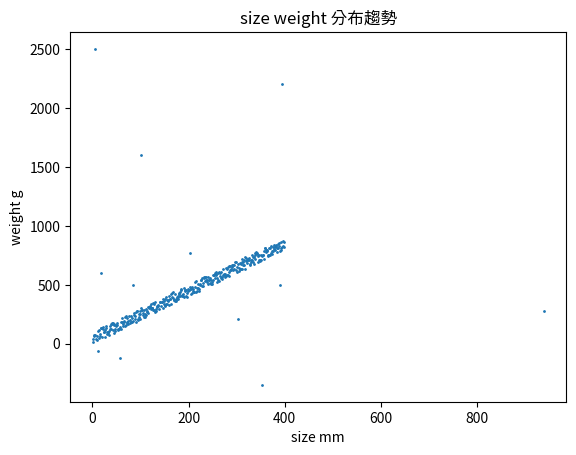

In [107]:
import matplotlib.pyplot as plt
import matplotlib as mlb
from matplotlib.font_manager import fontManager
font_path = os.path.join(project_dir, 'resources', 'fonts',"ChineseFont.ttf")
fontManager.addfont(font_path)
mlb.rc("font",family="ChineseFont")
plt.scatter(data['size'], data['weight'], s=1)
plt.title('size weight 分布趨勢')
plt.xlabel('size mm')
plt.ylabel('weight g')
plt.show()

滿好的線性關係(如預期)
但是除了剛才的負數不合理以外，部分隕石重量似乎有異常(大約10mm的隕石竟然有2.5kg),明顯是異常的。
前面與廠商確認的過程，可預期他們會有一些量測疏失，所以需要拿捏如何應對異常與正常的誤差。

突然想到一個，那他們是否會有值是忘記填的?

4. Check for Missing Values: (If you don't do this main problem first, remain might be affected.)

Missing values can impact the model's performance or affect pyplot presentation. Identify if there are any and decide on a strategy to handle them (e.g., imputation, deletion).

In [108]:
data.isnull().sum()

size      3
weight    3
dtype: int64

沒想到有漏填的...

我們先把兩種確定有問題的資料移除再繼續:
1. 漏掉紀錄重量/長度
2. 重量不大於0


In [109]:
data_dropped_na = data.dropna()
print("Original data shape:", data.shape)
print("After dropping NA:", data_dropped_na.shape)  # Removed 6 items
# 沒必要用平均數填入，畢竟可能弄巧成拙
# data['x'].fillna(data['x'].mean(), inplace=True)1

Original data shape: (399, 2)
After dropping NA: (393, 2)


In [110]:
# 再移除重量不大於0
data_positive_weight = data_dropped_na[data_dropped_na['weight'] > 0]
print("After ensuring positive weights:", data_positive_weight.shape)  # Removed 3 more items


After ensuring positive weights: (390, 2)


我想再看一次整理過的資料在圖上分布如何，由於將往後常重複做這動作，我改成用class包起來方便用

In [111]:
import matplotlib.pyplot as plt
import matplotlib as mlb
from matplotlib.font_manager import fontManager
font_path = os.path.join(project_dir, 'resources', 'fonts',"ChineseFont.ttf")

class DataPlotter:
    def __init__(self, font_path):
        fontManager.addfont(font_path)
        mlb.rc("font", family="ChineseFont")
    
    def scatter_plot(self, x, y, x_label, y_label, title, point_size=1):
        plt.scatter(x, y, s=point_size)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.show()
        


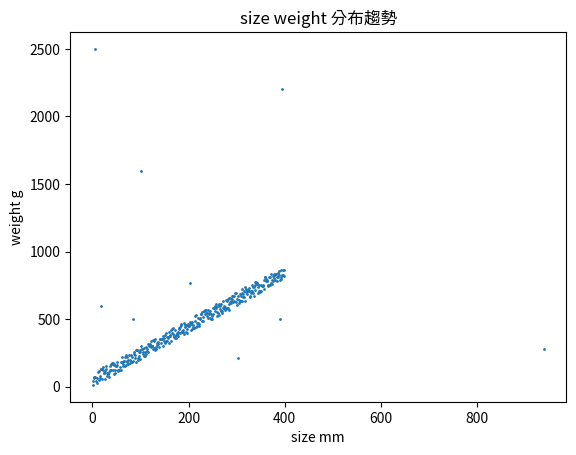

In [112]:
#實際用法:
plotter = DataPlotter(font_path)
plotter.scatter_plot(data_positive_weight['size'], data_positive_weight['weight'], 'size mm', 'weight g', 'size weight 分布趨勢')

繼續，部分隕石重量似乎有異常，這裡箱形圖呈現出明顯部分數值異常。(有評估過不合理)
用IQR (Interquartile Range) method把太大誤差的移除，不然會加減影響常態數值

5. Check for Outliers
Outliers can distort the relationship and lead to a poor model. Use box plots or scatter plots to visually inspect for any outliers. If identified, you'll need to decide whether to keep, modify, or remove them during the data preprocessing step.

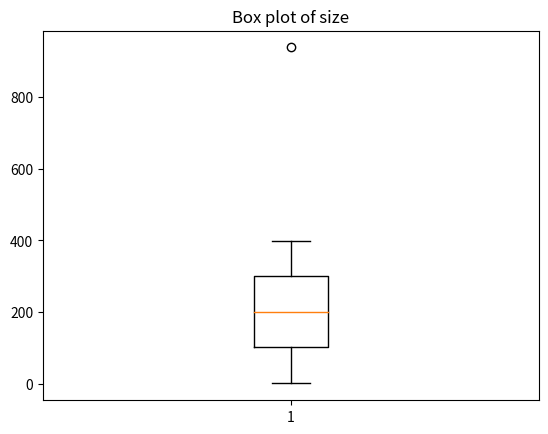

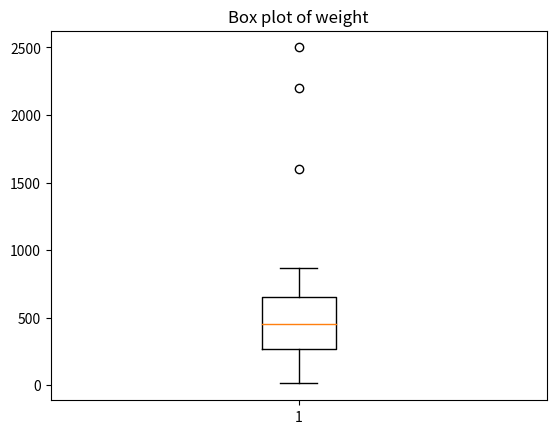

In [113]:
plt.boxplot(data_positive_weight['size'])
plt.title('Box plot of size')
plt.show()

plt.boxplot(data_positive_weight['weight'])
plt.title('Box plot of weight')
plt.show()

In [114]:
#  IQR (Interquartile Range) method
dt = data_positive_weight# 因為名稱太長...
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

outliers_count = ((dt < (Q1 - 1.5 * IQR)) | (dt > (Q3 + 1.5 * IQR))).sum()
print(outliers_count)

data_no_outliers = dt[~((dt < (Q1 - 1.5 * IQR)) | (dt > (Q3 + 1.5 * IQR))).any(axis=1)]

size      1
weight    3
dtype: int64


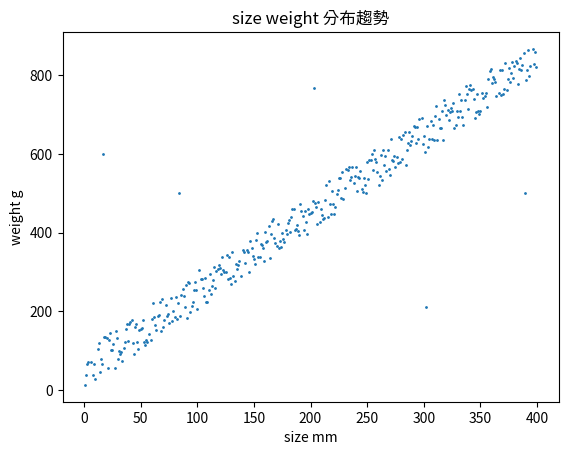

In [115]:
#直接用剛做的圖表class再次呈現
plotter.scatter_plot(data_no_outliers['size'], data_no_outliers['weight'], 'size mm', 'weight g', 'size weight 分布趨勢')


現在看起來合理乾淨多了! 來看看數據間相關性八!

6. Correlation Analysis
For linear regression, understanding how strongly the independent variable correlates with the dependent variable can be insightful. You can calculate the Pearson correlation coefficient.

In [116]:
correlation = data_no_outliers['size'].corr(data_no_outliers['weight'])
print(f'Correlateion between size and width: {correlation:.2f}')

Correlateion between size and width: 0.97


目前是均勻分布，其他特殊分布先不討論，這步驟的意義之後其他範例再探討。

7. Distribution Analysis
Understanding the distribution of your variables can be helpful, especially if you need to transform them later (e.g., if the data is highly skewed). Use histograms to visualize the distribution.

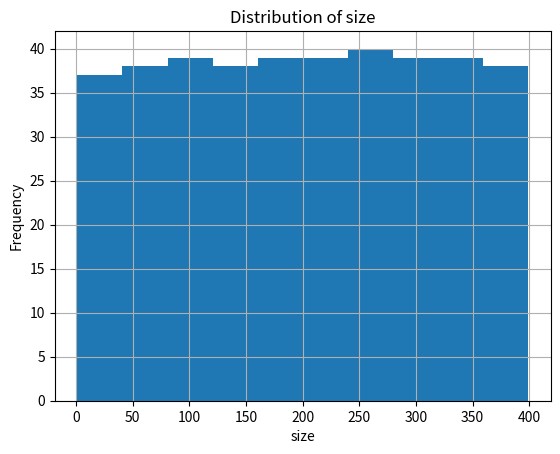

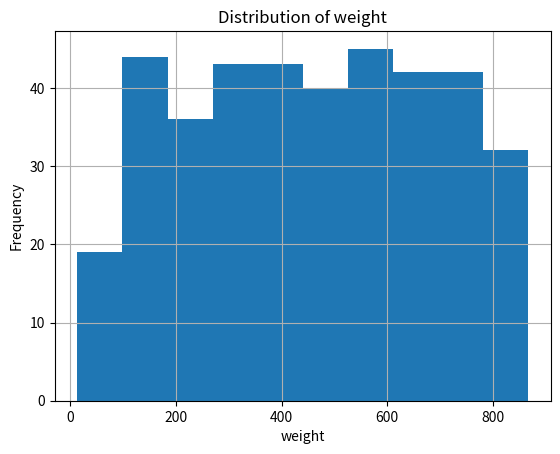

In [118]:
data_no_outliers['size'].hist()
plt.title('Distribution of size')
plt.xlabel('size')
plt.ylabel('Frequency')
plt.show() 

data_no_outliers['weight'].hist()
plt.title('Distribution of weight')
plt.xlabel('weight')
plt.ylabel('Frequency')
plt.show()

8. Document Findings
Keep notes on your findings. This can be in the form of comments in the initial_eda.ipynb notebook or a separate document. Note any potential issues with the data or interesting patterns you observe.

Once you've completed the EDA, you should have a good understanding of your data's characteristics. This knowledge will guide you in the data preprocessing and model building steps.